In [1]:
from fenics import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np
import sys, os, sympy, shutil, math
parameters.plotting_backend = "matplotlib"
%matplotlib inline
parameters.form_compiler.update({"optimize": True, "cpp_optimize": True, 
                                 "representation":"quadrature", "quadrature_degree": 2})

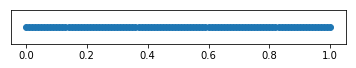

In [2]:
L = 1.; H = 0.1;
cell_size = 0.02;
nel = int(L/cell_size)
mesh = UnitIntervalMesh(100)
ndim = mesh.topology().dim() # get number of space dimensions
plot(mesh)

### Boundary indicators  (skip) 
We define below boundary indicators to impose boundary conditions and add the corresponding tags to the boundaries.

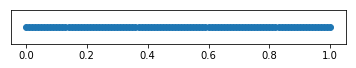

In [3]:
left = CompiledSubDomain("near(x[0], 0, 1e-4)")
right = CompiledSubDomain("near(x[0], %s, 1e-4)"%L)
boundaries = FacetFunction("size_t", mesh)
boundaries.set_all(0)
left.mark(boundaries, 1) # mark left as 1
right.mark(boundaries, 2) # mark right as 2
ds = Measure("ds",subdomain_data=boundaries) # left: ds(1), right: ds(2)
plot(mesh)

# Variational formulation of the problem

In [4]:
E = Constant(100.0)
Gc = Constant(1.0)
ell = Constant(0.05)
c1 = Constant(0.)
c2 = Constant(.05)
dt = 0.01
load0 = float(eps_c)*L # reference value for the loading (imposed displacement)
load_max = load0*1.5
load_min = 0.
nsteps = int((load_max-load_min)/dt)
loads = load0*np.linspace(0,1.5,nsteps)
print(nsteps)

NameError: name 'eps_c' is not defined

In [ ]:
def w(alpha):
    """Dissipated energy function as a function of the damage """
    return alpha

def a(alpha):
    """Stiffness modulation as a function of the damage """
    k_ell = Constant(1.e-6) # residual stiffness
    return (1-alpha)**2+k_ell

def eps(u):
    """Strain tensor as a function of the displacement"""
    return u.dx(0)

def sigma_0(u):
    """Stress tensor of the undamaged material as a function of the displacement"""
    return E*eps(u)

def sigma(u,alpha):
    """Stress tensor of the damaged material as a function of the displacement and the damage"""
    return (a(alpha))*sigma_0(u)

z = sympy.Symbol("z")
c_w = 4*sympy.integrate(sympy.sqrt(w(z)),(z,0,1))
print("c_w = ",c_w)
c_1w = sympy.integrate(sympy.sqrt(1/w(z)),(z,0,1))
print("c_1/w = ",c_1w)
tmp = 2*(sympy.diff(w(z),z)/sympy.diff(1/a(z),z)).subs({"z":0})
sigma_c = sympy.sqrt(tmp*Gc*E/(c_w*ell))
print("sigma_c = %2.3f"%sigma_c)
eps_c = float(sigma_c/E)
print("eps_c = %2.3f"%eps_c)


## Finite element function space

We use $P_1$ finite element (triangle with linear Lagrange polynomial as shape functions and nodal values as dofs) for both displacement and damage. 

In [ ]:
# Create function space for 2D elasticity + Damage
V_u = FunctionSpace(mesh, "P", 1)
V_alpha = FunctionSpace(mesh, "P", 1)

# Define the function, test and trial fields
u, du, v = Function(V_u), TrialFunction(V_u), TestFunction(V_u)
alpha, dalpha, beta = Function(V_alpha), TrialFunction(V_alpha), TestFunction(V_alpha)
u.rename('displacement','displacement')
alpha.rename('damage','damage')

In [ ]:
# Displacement
u_R = Expression("t",t = 0.,degree=0)
bcu_0 = DirichletBC(V_u, u_R, boundaries, 2)
bcu_1 = DirichletBC(V_u, Constant(0.), boundaries, 1)
bc_u = [bcu_0, bcu_1]
# Damage
bcalpha_0 = DirichletBC(V_alpha, 0.0, boundaries, 1)
bcalpha_1 = DirichletBC(V_alpha, 0.0, boundaries, 2)
bc_alpha = [bcalpha_0, bcalpha_1]
# bounds
lb = interpolate(Constant("0."), V_alpha) # lower bound, initialize to 0
ub = interpolate(Constant("1."), V_alpha) # upper bound, set to 1
for bc in bc_alpha:
    bc.apply(lb.vector())
    bc.apply(ub.vector())
# Formulation     
elastic_energy = 0.5*inner(sigma(u,alpha), eps(u))*dx
dissipated_energy = Gc/float(c_w)*(w(alpha)/ell + ell*dot(grad(alpha), grad(alpha)))*dx
visco_energy= 0.5/dt*c1*((alpha-lb)**2)*dx + 0.5/dt*c2*(dot(grad((alpha-lb)),grad((alpha-lb))))*dx 
total_energy = elastic_energy + dissipated_energy + visco_energy
# First directional derivative wrt u
E_u = derivative(total_energy,u,v)
# First and second directional derivative wrt alpha
E_alpha = derivative(total_energy,alpha,beta)
E_alpha_alpha = derivative(E_alpha,alpha,dalpha)

### Boundary conditions
We impose the boundary conditions on the displacement and the damage field. 
- We impose null damage where there are Dirichlet boundary condition on the displacement
- We use an Expression for the imposed displacement to vary it during the loading history

# Solvers

### Displacement problem
The $u$-problem at fixed $\alpha$ is a linear problem corresponding with linear elasticity. We solve it with a standard linear solver. We use automatic differention to get the first derivative of the energy. We use a direct solve to solve the linear system (`umfpack`), but you can also easily set iterative solvers and preconditioners when solving large problem in parallel.

In [ ]:
E_du = replace(E_u,{u:du})
problem_u = LinearVariationalProblem(lhs(E_du), rhs(E_du), u, bc_u)
solver_u = LinearVariationalSolver(problem_u)
solver_u.parameters.update({"linear_solver" : "umfpack"})

### Damage problem with bound-constraints

The $\alpha$-problem at fixed $u$ is a variational inequality, because of the irreversibility constraint. We solve it using a specific solver for optimisation problems with bound-constraints provided by `PETSC`, called `TAO`. To this end we define with a specific syntax a class defining the function to be minimised, and the lower (`lb`) and upper (`ub`) bounds. 

In [ ]:
class DamageProblem(OptimisationProblem):

    def f(self, x):
        """Function to be minimised"""
        alpha.vector()[:] = x
        return assemble(total_energy)

    def F(self, b, x):
        """Gradient (first derivative)"""
        alpha.vector()[:] = x
        assemble(E_alpha, b)

    def J(self, A, x):
        """Hessian (second derivative)"""
        alpha.vector()[:] = x
        assemble(E_alpha_alpha, A)

solver_alpha_tao = PETScTAOSolver()
solver_alpha_tao.parameters.update({"method": "tron","linear_solver" : "umfpack", 
                                    "line_search": "gpcg", "report": True})


### Alternate minimization

We solve the nonlinear problem in $(u,\alpha)$ at each time-step by a fixed-point algorithm consisting in alternate minimization with respect to $u$ at fixed $\alpha$ and viceversa, *i.e.* we solve till convergence the $u$- and the $\alpha$-problems above.

In [ ]:
def alternate_minimization(u,alpha,tol=1.e-5,maxiter=100,alpha_0=interpolate(Constant("0.0"), V_alpha)):
    # initialization
    iter = 1; err_alpha = 1
    alpha_error = Function(V_alpha)
    # iteration loop
    while err_alpha>tol and iter<maxiter:
        # solve elastic problem
        solver_u.solve()
        # solve damage problem
        #solver_alpha.solve()
        solver_alpha_tao.solve(DamageProblem(), alpha.vector(), lb.vector(), ub.vector())# test error
        alpha_error.vector()[:] = alpha.vector() - alpha_0.vector()
        err_alpha = np.linalg.norm(alpha_error.vector().array(), ord = np.Inf)
        # monitor the results
        if mpi_comm_world().rank == 0:
            print("Iteration:  %2d, Error: %2.8g, alpha_max: %.8g" %(iter, err_alpha, alpha.vector().max()))
        # update iteration
        alpha_0.assign(alpha)
        iter=iter+1
    return (err_alpha, iter)

## Time-step post-processing (skip)

We define here a utility function performing some post-processing to do at the end of each time-step.
You can sefely skip reading this section in a first reading of the code. 

In [ ]:
savedir = "results/"
if os.path.isdir(savedir):
    shutil.rmtree(savedir)    
file_alpha = File(savedir+"/alpha.pvd") 
file_u = File(savedir+"/u.pvd") 
#  loading and initialization of vectors to store time datas
energies = np.zeros((len(loads),5))
iterations = np.zeros((len(loads),2))
forces = np.zeros((len(loads),2))
def postprocessing():
    plt.figure(i_t)
    plot(alpha, range_min = 0., range_max = 1., title = "Damage at loading %.4f"%t)
    # Save number of iterations for the time step
    iterations[i_t] = np.array([t,i_t])
    # Calculate the energies
    elastic_energy_value = assemble(elastic_energy)
    surface_energy_value = assemble(dissipated_energy)
    visco_energy_value = assemble(visco_energy)
    if mpi_comm_world().rank == 0:
        print("\nEnd of timestep %d with load %g"%(i_t, t))
        print("\nElastic and surface energies: (%g,%g)"%(elastic_energy_value,surface_energy_value))
        print("-----------------------------------------")
    energies[i_t] = np.array(
        [t,elastic_energy_value,
         surface_energy_value,
         elastic_energy_value+surface_energy_value,
         visco_energy_value+sum(energies[:,4])])
    # Calculate the axial force resultant
    forces[i_t] = np.array([t,assemble(sigma(u,alpha)*ds(1))])
    # Dump solution to file
    file_alpha << (alpha,t)
    file_u << (u,t)
    # Save some global quantities as a function of the time
    np.savetxt(savedir+'/energies.txt', energies)
    np.savetxt(savedir+'/forces.txt', forces)
    np.savetxt(savedir+'/iterations.txt', iterations)
    #print(energies[:,4])

## Solving at each time instant and loop in time

Here we solve the problem finding the solution at each time step. This can take time. Computations are performed here.

In [ ]:
lb.interpolate(Constant(0.))
for (i_t, t) in enumerate(loads):
    u_R.t = t
    # solve alternate minimization
    alternate_minimization(u,alpha,maxiter=30)
    # updating the lower bound to account for the irreversibility
    lb.vector()[:] = alpha.vector()
    postprocessing()


# Postprocessing (skip)
We show the final deformed configuration and damage field

Hence we plot the energy and the traction force as a function of the loading

In [ ]:
def critical_stress():
    xs = sympy.Symbol('x')
    wx = w(xs); sx = 1/(E*H*a(xs));
    res = sympy.sqrt(2*(Gc*H/c_w)*wx.diff(xs)/(sx.diff(xs)*ell))
    return res.evalf(subs={xs:0})

def plot_stress():
    plt.plot(forces[:,0], forces[:,1], 'b*', linewidth = 2)
    plt.xlabel('Displacement')
    plt.ylabel('Force')
    force_cr = critical_stress()
    plt.axvline(x = force_cr/(E*H)*L, color = 'grey', linestyle = '--', linewidth = 2)
    plt.axhline(y = force_cr, color = 'grey', linestyle = '--', linewidth = 2)

def plot_energy():
    p1, = plt.plot(energies[:,0], energies[:,1],'b*',linewidth=2)
    p2, = plt.plot(energies[:,0], energies[:,2],'r^',linewidth=2)
    p3, = plt.plot(energies[:,0], energies[:,3],'ko',linewidth=2)
    p4, = plt.plot(energies[:,0], energies[:,4],'g+',linewidth=2)
    plt.legend([p1, p2, p3,p4], ["Elastic","Dissipated", "Total", "Visco"])
    plt.xlabel('Displacement')
    plt.ylabel('Energies')
    force_cr = critical_stress()
    plt.axvline(x = force_cr/(E*H)*L, color = 'grey',linestyle = '--', linewidth = 2)
    plt.axhline(y = H,color = 'grey', linestyle = '--', linewidth = 2)

def plot_energy_stress():
    plt.subplot(211)
    plot_stress()
    plt.subplot(212)
    plot_energy()
    plt.savefig(savedir+'/energies_force.png')
    plt.show()

plot_energy_stress()

# Verification

The plots above indicates that the crack appear at the elastic limit calculated analytically (see the gridlines) and that the dissipated energy coincide with the length of the crack times $G_c$. Let's check the latter explicity

In [ ]:
print("The dissipated energy on a crack is %.3f"%assemble(dissipated_energy))
print("The expeceted value is %f"%H)

Let us look at the damage profile

In [ ]:
xs = np.linspace(L/3,2*L/3,1000)
plt.plot(xs,[alpha(x,H/2.) for x in xs], '-', label="damage profile")
plt.xlabel("x")
plt.ylabel("alpha")
plt.title("Damage profile")
print("The expected half-width of the damage localisation is %.2f"%float(c_1w*ell))

We can see that the over-dissipation in the finite element approcimation is due to the central element with unit damage, which should be a single point in the inifinite dimensional model. The error can be estimated as $G_c/c_w \ell*H*h$, where $h$ is the mesh size. Let's check this estimation

In [ ]:
Gcerr = float(Gc/c_w/ell)*mesh.hmax()*H
print(Gcerr)

This give a better agreement with the analytical result for infinite dimensional model. A numerical trick is to incorporate this error using a corrected value of the fracture toughness to use in the numerical simulations:
$$
    G_c^\mathrm{num}=\frac{G_c}{\left(1+\frac{h}{\ell}c_w\right)}
$$

In [ ]:
print("The corrected value of the dissipated energy in the discrete model is %f"% float(Gcerr+Gc*H))
print("The dissipated energy on a crack is %.3f"%assemble(dissipated_energy))